In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Imports
from backtest_utils import TradingSimulator
import pickle

In [7]:
strategy_name = 'dumb_strategy'
TS = TradingSimulator(strategy_name)

NOTICE: self.strategy: Need to use strategy_vault to automatically load the strategy based on strategy name (need to basically do a dynamic import


In [8]:
# Dump New symbols into the stock_symbols.pkl
stock_symbols_pickle = 'stock_symbols.pkl'  # Name of the pickle file
symbols = []  # Example list of stock symbols
if len(symbols) > 0:
    TS.SAU.add_stock_symbols_to_pickle(symbols, stock_symbols_pickle)

In [9]:
# Load the data from 'stock_symbols.pkl' into a variable called 'symbols'
with open(stock_symbols_pickle, 'rb') as file:
    symbols = pickle.load(file)

In [10]:
stock_symbols_pickle = 'stock_symbols.pkl'  # Name of the pickle file
TS.SAU.update_stock_data(pickle_file=stock_symbols_pickle)

Updating data for LIFW...


/Users/vandanchopra/Vandan_Personal_Folder/CODE_STUFF/Projects/mathematricks/venv/lib/python3.10/site-packages/yfinance/utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
[*********************100%%**********************]  1 of 1 completed
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
[*********************100%%**********************]  1 of 1 completed

Data for LIFW updated in data/LIFW.csv.
Updating data for SRL...



  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
[*********************100%%**********************]  1 of 1 completed

Data for SRL updated in data/SRL.csv.
Updating data for SLAMW...



  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
[*********************100%%**********************]  1 of 1 completed

Data for SLAMW updated in data/SLAMW.csv.
Updating data for BFRI...



  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
[*********************100%%**********************]  1 of 1 completed

Data for BFRI updated in data/BFRI.csv.
Updating data for HQY...



  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
[*********************100%%**********************]  1 of 1 completed

Data for HQY updated in data/HQY.csv.
Updating data for COYA...



  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
[*********************100%%**********************]  1 of 1 completed

Data for COYA updated in data/COYA.csv.
Updating data for SYF...



  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
[*********************100%%**********************]  1 of 1 completed

Data for SYF updated in data/SYF.csv.
Updating data for IRAA...



  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
[*********************100%%**********************]  1 of 1 completed

Data for IRAA updated in data/IRAA.csv.
Updating data for BRKR...



  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
[*********************100%%**********************]  1 of 1 completed

Data for BRKR updated in data/BRKR.csv.
Updating data for HBT...


KeyboardInterrupt: 

## BACKTEST

In [111]:
# Imports
from datetime import datetime

# Optional Imports
import numpy as np
import matplotlib.pyplot as plt

In [112]:
symbols = ['HDB', 'BIIB', 'BNTX', 'MRNA', 'CHTR', 'AWK', 'SNAP', 'TFC', 'ES', 'KDP', 'HSY', 'NEE', 'TTWO', 'EL', 'JD', 'BA', 'EQNR', 'HUM', 'NTR', 'WPM', 'WPM', 'WBA', 'SBAC', 'MMM', 'BTI', 'ILMN', 'WDS', 'ADM', 'PFE', 'ALNY', 'FNV', 'NEM', 'WBD']


In [126]:
from backtest_utils import TradingSimulator
TS = TradingSimulator(strategy_name)
start_date = '2018-01-01'
end_date = '2020-12-31'
start_date_dt = datetime.strptime(start_date, "%Y-%m-%d")
end_date_dt = datetime.strptime(end_date, "%Y-%m-%d")
rebalance_frequency = 15  # In days
# create a numpy array of numbers 15 days apart from 0 to 365
long_count = 10
short_count = 0
portfolio_starting_value = 110000
risk_pct = 0.1
reinvest_profits_bool = False

# Run the backtest
test = TS.run_backtest(symbols, start_date_dt, end_date_dt, rebalance_frequency, long_count, short_count, portfolio_starting_value, risk_pct, reinvest_profits_bool)

# cProfile the backtest
# import cProfile
# cProfile.run('TS.run_backtest(symbols, start_date_dt, end_date_dt, rebalance_frequency, long_count, short_count, portfolio_starting_value, risk_pct, reinvest_profits_bool)', sort='cumtime')

test = TS.load_backtest(test["inputs"]["symbols"], start_date_dt, end_date_dt, rebalance_frequency, long_count, short_count, portfolio_starting_value, risk_pct, reinvest_profits_bool)



NOTICE: self.strategy: Need to use strategy_vault to automatically load the strategy based on strategy name (need to basically do a dynamic import
Error loading data for HDB: [Errno 2] No such file or directory: 'data/HDB.csv'
Error loading data for BIIB: [Errno 2] No such file or directory: 'data/BIIB.csv'
Error loading data for BNTX: [Errno 2] No such file or directory: 'data/BNTX.csv'
Error loading data for MRNA: [Errno 2] No such file or directory: 'data/MRNA.csv'
Error loading data for CHTR: [Errno 2] No such file or directory: 'data/CHTR.csv'
Error loading data for AWK: [Errno 2] No such file or directory: 'data/AWK.csv'
Error loading data for SNAP: [Errno 2] No such file or directory: 'data/SNAP.csv'
Error loading data for TFC: [Errno 2] No such file or directory: 'data/TFC.csv'
Error loading data for ES: [Errno 2] No such file or directory: 'data/ES.csv'
Error loading data for KDP: [Errno 2] No such file or directory: 'data/KDP.csv'
Error loading data for HSY: [Errno 2] No such

Running backtest: 2020-12-16 - 2020-12-30: 100%|██████████| 73/73 [00:00<00:00, 134.10it/s, Profit=-2051.66]


Backtest results saved to backtests/BaseStrategy_BA_EQNR_SBAC_2018-01-01_2020-12-31_15_10_0_110000_0.1_False.pkl
Backtest results loaded from backtests/BaseStrategy_BA_EQNR_SBAC_2018-01-01_2020-12-31_15_10_0_110000_0.1_False.pkl


In [127]:
strategy_profit = np.cumsum(test['backtest_profits'])[-1]
print(f"Strategy Profit: {strategy_profit}")

Strategy Profit: 63909.899748897624


In [128]:
benchmark_returns = TS.get_benchmark_returns(start_date_dt, end_date_dt, test['rebalance_periods'], portfolio_starting_value, benchmark_name='^IXIC')

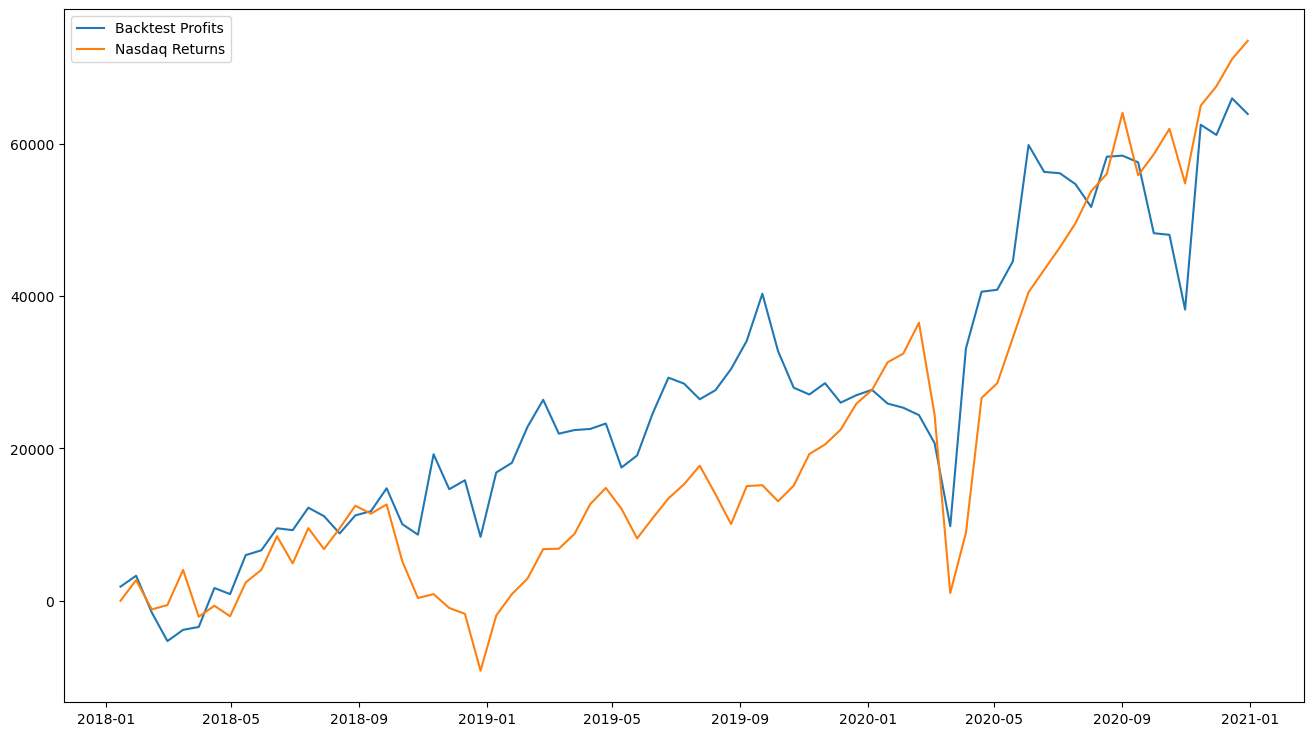

In [129]:
# Plot the backtest profits and the benchmark_data
plt.figure(figsize=(16, 9))
plt.plot(np.array(test['rebalance_periods'])[:, 1], np.cumsum(test['backtest_profits']), label='Backtest Profits')
plt.plot(np.array(test['rebalance_periods'])[:, 1], np.cumsum(benchmark_returns), label='Nasdaq Returns')
# Show labels
plt.legend()
# Show the plot
plt.show()

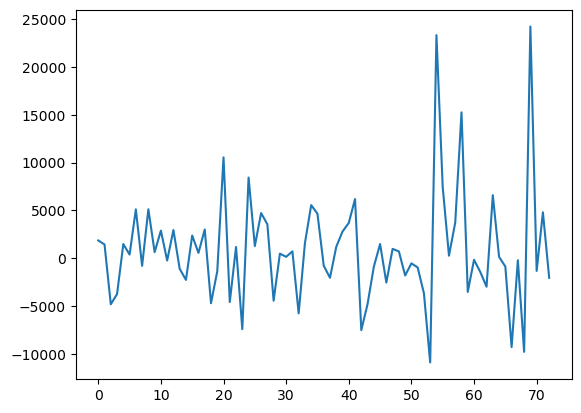

In [130]:
plt.plot(test['backtest_profits'])

# Verifying the backtest results

In [ ]:
sum = 0
for count in range(11):
    profit = test['backtest_runs'][count][-1].astype(np.float64).sum()
    print({count: profit})
    sum += profit
print(sum)

In [ ]:
rebal_period = 100
test['backtest_runs'][rebal_period]

In [ ]:
asset_num = 0
asset_name = test['backtest_runs'][rebal_period][0][asset_num]
buy_price = float(test['backtest_runs'][rebal_period][1][asset_num])
qty = float(test['backtest_runs'][rebal_period][2][asset_num])
stop_loss = float(test['backtest_runs'][rebal_period][3][asset_num])
sell_price = float(test['backtest_runs'][rebal_period][4][asset_num])
stoploss_hit = test['backtest_runs'][rebal_period][5][asset_num]
profit = float(test['backtest_runs'][rebal_period][6][asset_num])
print(f'Asset: {asset_name}, Buy Price: {buy_price}, Qty: {qty}, Stop Loss: {stop_loss}, Sell Price: {sell_price}, stoploss_hit:{stoploss_hit}, Profit: {profit}')

In [ ]:
verify_profit = (sell_price - buy_price) * qty
verify_profit

# ANALYSIS STUFF

In [ ]:
# Calculating Win % for Rebalance Periods

profit_count = 0
loss_count = 0
for backtest_run in backtest_runs:
    profit = backtest_run[-1]
    for output in profit:
        output = int(np.float32(output))
        if output > 0:
            profit_count += 1
        else:
            loss_count += 1
print({'profit_count': profit_count, 'loss_count': loss_count, 'profit_pct': profit_count/(profit_count+loss_count)})

In [ ]:
# calculate the sharp ratio
# https://www.youtube.com/watch?v=vTzjk6kLw2I

# IBKR Connection

In [ ]:
from ib_insync import IB, Stock
import nest_asyncio
nest_asyncio.apply()

In [ ]:
def connect_to_IBKR():
    '''NOTE: First start the TWS or Gateway software from IBKR'''
    
    # Create an instance of the IB class
    ib = IB()

    # Connect to the IBKR TWS (Trader Workstation) or Gateway
    ib.connect('127.0.0.1', 7496, clientId=0)

    # Check if the connection is successful
    if ib.isConnected():
        print('Connected to IBKR')
    else:
        print('Failed to connect to IBKR')
    return ib

In [ ]:
def get_current_portfolio(ib):
    # Request the current portfolio from IBKR
    portfolio = ib.portfolio()
    
    # Return the portfolio
    return portfolio


In [ ]:
def get_current_price(ib):
    # Request the current market data for AAPL
    contract = ib.qualifyContracts(Stock('AAPL', 'SMART', 'USD'))
    ticker = ib.reqTickers(contract)[0]
    
    # Get the current price
    current_price = ticker.marketPrice()
    
    # Return the current price
    return current_price


In [ ]:
get_current_price(ib)

In [ ]:
import pandas as pd
# load the csv file and put all the data in a pandas dataframe: path: 
nasdaq_screener_path = '/Users/vandanchopra/Downloads/nasdaq_screener_1709270654053.csv'
nasdaq_screener = pd.read_csv(nasdaq_screener_path)

In [ ]:
symbols_list = nasdaq_screener[nasdaq_screener['Industry'].isna()]['Symbol'].to_list()

In [ ]:
# from nasdaq_screener pandas df filter remove all symbols whose industry isna()
symbols_list_2 = nasdaq_screener.dropna(subset=['Industry'])['Symbol'].to_list()

